In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits

import scipy.stats

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp


from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

In [2]:
plt.style.use('notebook')

## Load catalog & definitions

In [3]:
t = Table.read('/home/ana/data/rcat_V2.1_MSG.fits')
ind = np.isfinite(t['GAIADR2_PMRA']) & (t['FLAG']==0) & (t['SNR']>10) & (t['E_tot_pot1']<0)
t = t[ind]
print(len(t))

age = 10**t['logAge']*1e-9
age_lerr = age - 10**(t['logAge']-t['logAge_lerr'])*1e-9
age_uerr = 10**(t['logAge']+t['logAge_uerr'])*1e-9 - age
age_err = 0.5 * (age_lerr + age_uerr)
age_err_cons = np.maximum(age_lerr, age_uerr)
age_err_min = 1
age_err_cons[age_err_cons<age_err_min] = age_err_min
age_invar = (age_err_cons)**-2

/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


27962


In [4]:
# blue = '#0039d3'
# purple = '#4700d3'
# orange = '#ff6200'
# pink = '#ee0449'

blue = '#0043c7'
orange = '#db3700'
gold = '#ffa006'

In [5]:
ind_all = np.ones(len(t), dtype='bool')
ind_z = (np.abs(t['Z_gal'])<1)
loggmin, loggmax = 3.8, 4.3
ind_safeage = (t['logg']>loggmin) & (t['logg']<loggmax) #& (t['logg_err']<0.1)
# ind_safeage = (t['logg']>3.8) & (t['logg']<4.3) & (age_err/age<0.15)
print(np.sum(ind_safeage))

11034


In [6]:
ind_highe = (t['eccen_pot1']>0.75)
ind_lowe = (t['eccen_pot1']<0.25)

p_ge = [-0.32,-0.02]
poly_ge = np.poly1d(p_ge)

p_splash = [-0.14,0.18]
poly_splash = np.poly1d(p_splash)

p_lowa = [-0.14,0.15]
poly_lowa = np.poly1d(p_lowa)

ind_lowachem = (t['init_FeH']>-0.45) & (t['init_aFe']<poly_lowa(t['init_FeH']))
ind_lowa = ind_lowe & ind_lowachem

ind_mpoor = (t['init_FeH']<-0.6) & (t['init_aFe']<poly_ge(t['init_FeH']))
ind_ge = ind_mpoor & ind_highe

ind_tdchem = (t['init_FeH']>-0.75) & (t['init_aFe']>poly_splash(t['init_FeH']))
ind_splash = ind_tdchem & ind_highe
ind_thick = ind_tdchem & (t['eccen_pot1']<0.5)

In [16]:
z = np.array([0.5,1,2,5,10])
zlabel = [('%f' % x).rstrip('0').rstrip('.') for x in z]
lookback = cosmo.lookbackTime(z)

In [38]:
tw = Table.read('/home/ana/data/wcat_V2.1_MSG[ebv_alpha_age_turnoff_PSr].fits')
tw = tw[ind]

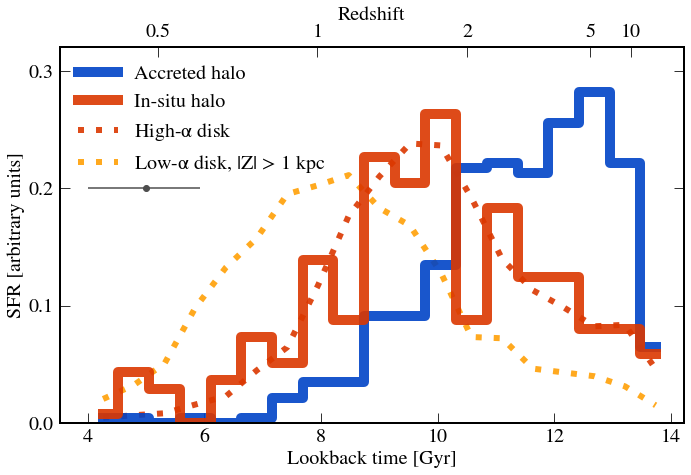

In [47]:
# ivar = age_err**-1
ivar = np.ones_like(age_err)

# ivar = tw['total_weight']**-1
# ind_bad = (tw['total_weight']<=0) | (ivar>3000)
abins = np.linspace(4,14,20)
abcen = 0.5 * (abins[1:] + abins[:-1])

h_accreted, be = np.histogram(age[ind_safeage & ind_ge & ~ind_bad], weights=ivar[ind_safeage & ind_ge & ~ind_bad],
                              bins=abins, density=True)
h_insitu, be = np.histogram(age[ind_safeage & ind_splash & ~ind_bad],
                            weights=ivar[ind_safeage & ind_splash & ~ind_bad], bins=abins, density=True)
h_higha, be = np.histogram(age[ind_safeage & ind_thick & ~ind_bad],
                           weights=ivar[ind_safeage & ind_thick & ~ind_bad], bins=abins, density=True)
h_lowa, be = np.histogram(age[ind_safeage & ind_lowa & ~ind_bad], 
                          weights=ivar[ind_safeage & ind_lowa & ~ind_bad], bins=abins, density=True)

plt.figure(figsize=(10,7))

plt.plot(abcen, h_accreted, color=blue, lw=10, alpha=0.9, drawstyle='steps-mid', label='Accreted halo')
plt.plot(abcen, h_insitu, color=orange, lw=10, alpha=0.9, drawstyle='steps-mid', label='In-situ halo')
plt.plot(abcen, h_higha, color=orange, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='High-$\\alpha$ disk')
plt.plot(abcen, h_lowa, color=gold, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='Low-$\\alpha$ disk, |Z| > 1 kpc')

plt.errorbar(np.array([5]), np.array([0.2]), yerr=None,
             xerr=np.array([np.median(age_lerr[ind_safeage]), np.median(age_uerr[ind_safeage])])[:,np.newaxis],
             fmt='o', color='0.3', capsize=0)

plt.ylim(0,0.32)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend(loc=2, frameon=False )
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [arbitrary units]')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(lookback)
ax2.set_xticklabels(zlabel)
ax2.set_xlabel('Redshift')

plt.tight_layout()
plt.savefig('../plots/ages_counts.png')

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  after removing the cwd from sys.path.


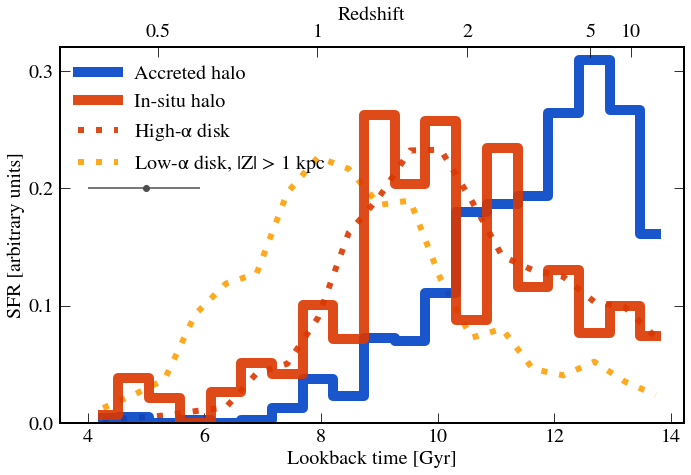

In [46]:
ivar = age_err**-1
ivar = np.ones_like(age_err)

ivar = tw['total_weight']**-1
ind_bad = (tw['total_weight']<=0) | (ivar>3000)
abins = np.linspace(4,14,20)
abcen = 0.5 * (abins[1:] + abins[:-1])

h_accreted, be = np.histogram(age[ind_safeage & ind_ge & ~ind_bad], weights=ivar[ind_safeage & ind_ge & ~ind_bad],
                              bins=abins, density=True)
h_insitu, be = np.histogram(age[ind_safeage & ind_splash & ~ind_bad],
                            weights=ivar[ind_safeage & ind_splash & ~ind_bad], bins=abins, density=True)
h_higha, be = np.histogram(age[ind_safeage & ind_thick & ~ind_bad],
                           weights=ivar[ind_safeage & ind_thick & ~ind_bad], bins=abins, density=True)
h_lowa, be = np.histogram(age[ind_safeage & ind_lowa & ~ind_bad], 
                          weights=ivar[ind_safeage & ind_lowa & ~ind_bad], bins=abins, density=True)

plt.figure(figsize=(10,7))

plt.plot(abcen, h_accreted, color=blue, lw=10, alpha=0.9, drawstyle='steps-mid', label='Accreted halo')
plt.plot(abcen, h_insitu, color=orange, lw=10, alpha=0.9, drawstyle='steps-mid', label='In-situ halo')
plt.plot(abcen, h_higha, color=orange, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='High-$\\alpha$ disk')
plt.plot(abcen, h_lowa, color=gold, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='Low-$\\alpha$ disk, |Z| > 1 kpc')

plt.errorbar(np.array([5]), np.array([0.2]), yerr=None,
             xerr=np.array([np.median(age_lerr[ind_safeage]), np.median(age_uerr[ind_safeage])])[:,np.newaxis],
             fmt='o', color='0.3', capsize=0)

plt.ylim(0,0.32)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend(loc=2, frameon=False )
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [arbitrary units]')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(lookback)
ax2.set_xticklabels(zlabel)
ax2.set_xlabel('Redshift')

plt.tight_layout()
plt.savefig('../plots/ages_weighted.png')

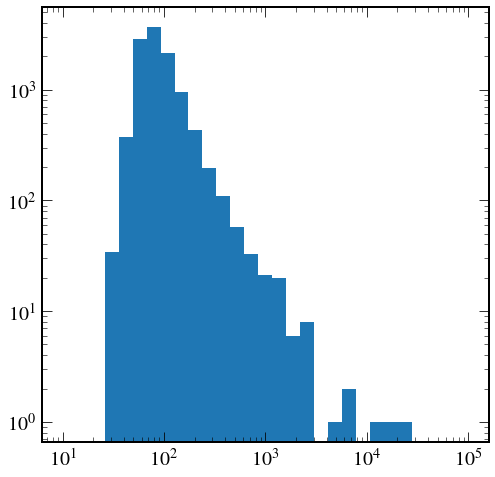

In [37]:
plt.hist(ivar, bins=np.logspace(1,5,30), log=True);

plt.gca().set_xscale('log')